# Hybrid Classification Pipeline

In [ ]:
import pandas as pd
import re
import nltk
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from transformers import RobertaTokenizer, RobertaModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

nltk_data_dir = "./nltk_data"
nltk.data.path.append(nltk_data_dir)
os.makedirs(nltk_data_dir, exist_ok=True)

nltk.download('punkt', download_dir=nltk_data_dir, quiet=True)
nltk.download('punkt_tab', download_dir=nltk_data_dir, quiet=True)
nltk.download('wordnet', download_dir=nltk_data_dir, quiet=True)
nltk.download('omw-1.4', download_dir=nltk_data_dir, quiet=True)
nltk.download('averaged_perceptron_tagger_eng', download_dir=nltk_data_dir, quiet=True)
nltk.download('stopwords', download_dir=nltk_data_dir, quiet=True)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using NVIDIA GPU (CUDA)")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

Using NVIDIA GPU (CUDA)
Device: cuda


In [ ]:
input_file = "../dataset/OBC_Cleaned.csv"
df = pd.read_csv(input_file)
df = df.dropna(how="all")

print(f"Loaded {len(df)} rows")
print(f"\nColumns: {list(df.columns)}")
print(f"\nVerdict distribution:\n{df['Verdict'].value_counts()}")
print(f"\nOffence distribution:\n{df['Offence'].value_counts()}")

Loaded 43389 rows

Columns: ['Trial_ID', 'Date', 'Defendant_Gender', 'Num_Defendants', 'Victim_Gender', 'Num_Victims', 'Offence', 'Offence_Subcategory', 'Verdict', 'Text_Length', 'Year', 'Trial_Text']

Verdict distribution:
Verdict
guilty       31253
notGuilty    12136
Name: count, dtype: int64

Offence distribution:
Offence
theft            35684
violentTheft      2410
deception         1436
breakingPeace     1204
sexual            1069
kill              1050
royalOffences      234
miscellaneous      152
damage             150
Name: count, dtype: int64


In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text_advanced(text):
    try:
        if not isinstance(text, str):
            return ""
        text = re.sub(r'^\s*[TM]\.\s*', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\b\w{1,2}\b', '', text)

        sentences = sent_tokenize(text)
        cleaned_sentences = []

        for sentence in sentences:
            words = word_tokenize(sentence.lower())
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            lemmatized_words = [
                lemmatizer.lemmatize(word, get_wordnet_pos(tag))
                for word, tag in tagged_words
            ]
            cleaned_sentences.append(" ".join(lemmatized_words))

        return " ".join(cleaned_sentences)
    except Exception as e:
        print(f"[ERROR] {e}")
        return text

def clean_text_basic(text):
    text = str(text)
    text = re.sub(r'^[\W\d\s]+', '', text)
    text = re.sub(r'[+*FO]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df["Trial_Text"] = df["Trial_Text"].astype(str).apply(clean_text_advanced)
df['Trial_Text'] = df['Trial_Text'].apply(clean_text_basic)

print("Text cleaning complete")


Text cleaning complete


In [5]:
df = df[df['Verdict'].isin(['guilty', 'notGuilty'])].copy()
df = df[df['Offence'] != 'Unknown'].copy()
df = df.drop_duplicates(subset="Trial_ID", keep="first")
df = df.drop_duplicates(subset="Trial_Text", keep="first")

df_not_guilty = df[df['Verdict'] == 'notGuilty']
df_guilty = df[df['Verdict'] == 'guilty']
min_count = min(len(df_not_guilty), len(df_guilty))

print(f"Before balancing: notGuilty={len(df_not_guilty)}, guilty={len(df_guilty)}")

df_not_guilty_balanced = df_not_guilty.sample(n=min_count, random_state=42)
df_guilty_balanced = df_guilty.sample(n=min_count, random_state=42)
df = pd.concat([df_not_guilty_balanced, df_guilty_balanced]).reset_index(drop=True)

print(f"After balancing: {len(df)} total rows")
print(f"\n{df['Verdict'].value_counts()}")


Before balancing: notGuilty=12136, guilty=31252
After balancing: 24272 total rows

Verdict
notGuilty    12136
guilty       12136
Name: count, dtype: int64


In [ ]:
label_map = {"guilty": 1, "notGuilty": 0}
df["Label"] = df["Verdict"].map(label_map)

offence_encoder = LabelEncoder()
df["Offence_Encoded"] = offence_encoder.fit_transform(df["Offence"])

year_scaler = StandardScaler()
df["Year_Scaled"] = year_scaler.fit_transform(df[["Year"]])

print(f"Number of offence categories: {len(offence_encoder.classes_)}")
print(f"Offence categories: {list(offence_encoder.classes_)}")
print(f"\nYear range: {df['Year'].min()} - {df['Year'].max()}")
print(f"\nMetadata features: Year_Scaled, Offence_Encoded (one-hot will be {len(offence_encoder.classes_)} dims)")

Number of offence categories: 9
Offence categories: ['breakingPeace', 'damage', 'deception', 'kill', 'miscellaneous', 'royalOffences', 'sexual', 'theft', 'violentTheft']

Year range: 1720 - 1913

Metadata features: Year_Scaled, Offence_Encoded (one-hot will be 9 dims)


In [7]:
class HybridCourtDataset(Dataset):
    def __init__(self, texts, labels, years_scaled, offences_encoded, tokenizer, num_offence_classes, max_len=512):
        self.texts = texts
        self.labels = labels
        self.years_scaled = years_scaled
        self.offences_encoded = offences_encoded
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.num_offence_classes = num_offence_classes

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

        year_feat = torch.tensor([self.years_scaled[idx]], dtype=torch.float)
        offence_onehot = torch.zeros(self.num_offence_classes, dtype=torch.float)
        offence_onehot[self.offences_encoded[idx]] = 1.0

        item["metadata"] = torch.cat([year_feat, offence_onehot])
        return item

    def __len__(self):
        return len(self.labels)

print("HybridCourtDataset class defined")


HybridCourtDataset class defined


In [8]:
class HybridRobertaClassifier(nn.Module):
    def __init__(self, num_metadata_features, num_labels=2, dropout=0.3):
        super(HybridRobertaClassifier, self).__init__()

        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.text_hidden_size = self.roberta.config.hidden_size

        self.metadata_encoder = nn.Sequential(
            nn.Linear(num_metadata_features, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

        combined_size = self.text_hidden_size + 32
        self.fusion = nn.Sequential(
            nn.Linear(combined_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

        self.classifier = nn.Linear(64, num_labels)

    def forward(self, input_ids, attention_mask, metadata, labels=None):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        text_features = roberta_output.last_hidden_state[:, 0, :]

        metadata_features = self.metadata_encoder(metadata)

        combined = torch.cat([text_features, metadata_features], dim=1)
        fused = self.fusion(combined)

        logits = self.classifier(fused)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}

print("HybridRobertaClassifier model defined")


HybridRobertaClassifier model defined


In [9]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        metadata = batch["metadata"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask, metadata, labels)
        loss = outputs["loss"]
        logits = outputs["logits"]

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            metadata = batch["metadata"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, metadata, labels)
            loss = outputs["loss"]
            logits = outputs["logits"]

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return avg_loss, accuracy, f1, all_preds, all_labels

print("Training and evaluation functions defined")


Training and evaluation functions defined


In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

texts = df["Trial_Text"].tolist()
labels = df["Label"].tolist()
years_scaled = df["Year_Scaled"].tolist()
offences_encoded = df["Offence_Encoded"].tolist()
num_offence_classes = len(offence_encoder.classes_)

num_metadata_features = 1 + num_offence_classes

print(f"Total samples: {len(texts)}")
print(f"Metadata features: {num_metadata_features} (1 year + {num_offence_classes} offence categories)")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Total samples: 24272
Metadata features: 10 (1 year + 9 offence categories)


In [11]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

NUM_EPOCHS = 5
BATCH_SIZE = 8
LEARNING_RATE = 2e-5

all_val_acc = []
all_val_f1 = []
all_train_loss = []
all_val_loss = []
best_model_state = None
best_val_acc = 0.0
best_fold = -1

print("Starting 10-fold cross-validation for Hybrid Model...")
print(f"Epochs: {NUM_EPOCHS}, Batch Size: {BATCH_SIZE}, LR: {LEARNING_RATE}")


Starting 10-fold cross-validation for Hybrid Model...
Epochs: 5, Batch Size: 8, LR: 2e-05



FOLD 1/10
Splitting data...
Data split complete
Creating datasets...
Datasets created
Loading RoBERTa model...


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded
Moving model to cuda...
Model moved to cuda
Setting up optimizer...
Optimizer ready

Starting training...

Epoch 1/5
  Train Loss: 0.3367, Train Acc: 0.8555
  Val Loss: 0.2260, Val Acc: 0.9156

Epoch 2/5
  Train Loss: 0.2129, Train Acc: 0.9170
  Val Loss: 0.2345, Val Acc: 0.9160

Epoch 3/5
  Train Loss: 0.1859, Train Acc: 0.9281
  Val Loss: 0.2876, Val Acc: 0.9197

Epoch 4/5
  Train Loss: 0.1715, Train Acc: 0.9391
  Val Loss: 0.3247, Val Acc: 0.9193

Epoch 5/5
  Train Loss: 0.1549, Train Acc: 0.9518
  Val Loss: 0.3425, Val Acc: 0.9238

Fold 1 Complete - Val Accuracy: 0.9238, Val F1: 0.9238
  New best model!


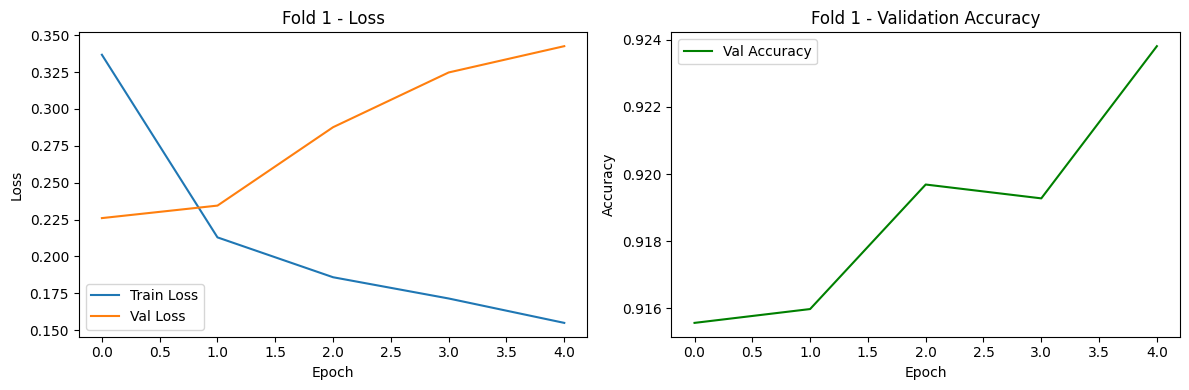

Cleaning up...
Cleanup complete

FOLD 2/10
Splitting data...
Data split complete
Creating datasets...
Datasets created
Loading RoBERTa model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded
Moving model to cuda...
Model moved to cuda
Setting up optimizer...
Optimizer ready

Starting training...

Epoch 1/5
  Train Loss: 0.3278, Train Acc: 0.8519
  Val Loss: 0.2452, Val Acc: 0.9049

Epoch 2/5


KeyboardInterrupt: 

In [12]:
for fold, (train_idx, val_idx) in enumerate(kfold.split(texts, labels)):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/10")
    print(f"{'='*50}")

    print("Splitting data...")
    train_texts = [texts[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    train_years = [years_scaled[i] for i in train_idx]
    train_offences = [offences_encoded[i] for i in train_idx]

    val_texts = [texts[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]
    val_years = [years_scaled[i] for i in val_idx]
    val_offences = [offences_encoded[i] for i in val_idx]
    print("Data split complete")

    print("Creating datasets...")
    train_dataset = HybridCourtDataset(train_texts, train_labels, train_years, train_offences,
                                        tokenizer, num_offence_classes)
    val_dataset = HybridCourtDataset(val_texts, val_labels, val_years, val_offences,
                                      tokenizer, num_offence_classes)
    print("Datasets created")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Loading RoBERTa model...")
    model = HybridRobertaClassifier(num_metadata_features=num_metadata_features)
    print("Model loaded")

    print(f"Moving model to {device}...")
    model.to(device)
    print(f"Model moved to {device}")

    print("Setting up optimizer...")
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    total_steps = len(train_loader) * NUM_EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=500,
                                                 num_training_steps=total_steps)
    print("Optimizer ready")

    fold_train_losses = []
    fold_val_losses = []
    fold_val_accs = []

    print(f"\nStarting training...")
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, device)

        fold_train_losses.append(train_loss)
        fold_val_losses.append(val_loss)
        fold_val_accs.append(val_acc)

        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    final_val_loss, final_val_acc, final_val_f1, preds, true_labels = evaluate(model, val_loader, device)

    all_val_acc.append(final_val_acc)
    all_val_f1.append(final_val_f1)
    all_train_loss.append(fold_train_losses[-1])
    all_val_loss.append(final_val_loss)

    print(f"\nFold {fold+1} Complete - Val Accuracy: {final_val_acc:.4f}, Val F1: {final_val_f1:.4f}")

    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_fold = fold
        best_model_state = model.state_dict().copy()
        print(f"  New best model!")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(fold_train_losses, label="Train Loss")
    plt.plot(fold_val_losses, label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(fold_val_accs, label="Val Accuracy", color="green")
    plt.title(f"Fold {fold+1} - Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("Cleaning up...")
    del model
    if torch.backends.mps.is_available():
        torch.mps.empty_cache()
    elif torch.cuda.is_available():
        torch.cuda.empty_cache()
    print("Cleanup complete")


In [ ]:
print("\n" + "="*60)
print("HYBRID MODEL - 10-FOLD CROSS-VALIDATION RESULTS")
print("="*60)
print(f"\nMean Validation Accuracy: {np.mean(all_val_acc):.4f} ± {np.std(all_val_acc):.4f}")
print(f"Mean Validation F1 Score: {np.mean(all_val_f1):.4f} ± {np.std(all_val_f1):.4f}")
print(f"Mean Training Loss: {np.mean(all_train_loss):.4f}")
print(f"Mean Validation Loss: {np.mean(all_val_loss):.4f}")
print(f"\nBest Fold: {best_fold + 1} with Accuracy: {best_val_acc:.4f}")

print("\nPer-Fold Results:")
print("-" * 40)
for i, (acc, f1) in enumerate(zip(all_val_acc, all_val_f1)):
    print(f"Fold {i+1}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")

In [ ]:
final_model_path = "./hybrid_roberta_best_model"
os.makedirs(final_model_path, exist_ok=True)

torch.save(best_model_state, os.path.join(final_model_path, "model_state.pt"))

tokenizer.save_pretrained(final_model_path)

import pickle
with open(os.path.join(final_model_path, "offence_encoder.pkl"), "wb") as f:
    pickle.dump(offence_encoder, f)
with open(os.path.join(final_model_path, "year_scaler.pkl"), "wb") as f:
    pickle.dump(year_scaler, f)

print(f"\nBest model saved to {final_model_path}")
print(f"  - model_state.pt (from fold {best_fold + 1})")
print(f"  - tokenizer files")
print(f"  - offence_encoder.pkl")
print(f"  - year_scaler.pkl")

## Comparison: Text-Only vs Hybrid

In [ ]:
hybrid_acc = all_val_acc

# text_only_acc = []

# if text_only_acc:
#     plt.figure(figsize=(10, 6))
#     x = np.arange(1, 11)
#     width = 0.35

#     plt.bar(x - width/2, text_only_acc, width, label='Text-Only (RoBERTa)', alpha=0.8)
#     plt.bar(x + width/2, hybrid_acc, width, label='Hybrid (RoBERTa + Metadata)', alpha=0.8)

#     plt.xlabel('Fold')
#     plt.ylabel('Validation Accuracy')
#     plt.title('Text-Only vs Hybrid Model Comparison')
#     plt.xticks(x)
#     plt.legend()
#     plt.axhline(y=np.mean(text_only_acc), color='blue', linestyle='--', alpha=0.5, label=f'Text-Only Mean: {np.mean(text_only_acc):.4f}')
#     plt.axhline(y=np.mean(hybrid_acc), color='orange', linestyle='--', alpha=0.5, label=f'Hybrid Mean: {np.mean(hybrid_acc):.4f}')
#     plt.tight_layout()
#     plt.show()

#     print(f"\nText-Only Mean Accuracy: {np.mean(text_only_acc):.4f}")
#     print(f"Hybrid Mean Accuracy: {np.mean(hybrid_acc):.4f}")
#     print(f"Improvement: {(np.mean(hybrid_acc) - np.mean(text_only_acc)) * 100:.2f}%")

print("Hybrid model accuracies per fold:", [f"{acc:.4f}" for acc in hybrid_acc])
